In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.colors
from scipy.ndimage.filters import gaussian_filter
from scipy.special import erf
from matplotlib.lines import Line2D
import h5py
import glob, json
from scipy.stats import gaussian_kde

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [30]:
#samps_no_evol = np.load('processed_emcee_samples_r00.npy')
samps = np.load('processed_emcee_samples_injection_qDependence_evol_partial5_r00.npy')

n_catalogs = 400

In [2]:
# Dicts with samples: 
bad = ["47535"]
sampleDict = {}
singleEvents = np.sort(glob.glob('./tmp/job*'))
for i,eventFile in enumerate(singleEvents):
    key = eventFile.split('_')[1].split('.')[0]
    if key in bad:
        continue
    else:
        dataDict = np.load(eventFile,allow_pickle=True,encoding='latin1')[()]
        sampleDict[key] = dataDict

# Initial Scatter

13446 0.19450831134069424 0.35549319779700417
20864 0.4647679838921984 0.36306287224510736
28026 0.28362603433605815 0.3739801179893315
36098 -0.12979629101883564 0.423645038178592
44551 0.544073559929671 0.33999266262137184


(0.0, 1.0)

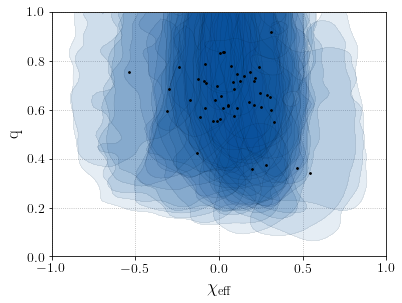

In [3]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i,key in enumerate(list(sampleDict.keys())):
    
    chis = sampleDict[key]['Xeff']
    m1s = sampleDict[key]['m1']
    m2s = sampleDict[key]['m2']
    qs = m2s/m1s
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,2)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    if np.median(qs)<0.45:
        print(key,np.median(chis),np.median(qs))
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    if key=='S190517h':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif key=='S190412m':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    elif key=='S190814bv':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#4daf4a',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.1)
 

"""
custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1),
                Line2D([0], [0], color='#4daf4a', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412', 'GW190814'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)
"""

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

In [16]:
def isotropic_pz(szs,aMax):
    return np.log(aMax/np.abs(szs))/(2.*aMax)

reweightedSampleDict = {}
bilby_output_files = np.sort(glob.glob('output/job_?????_result.json'))
for i,f in enumerate(bilby_output_files):
    
    with open(f,'r') as jf:
        result = json.load(jf)

    m1 = np.array(result['posterior']['content']['mass_1_source'])
    m2 = np.array(result['posterior']['content']['mass_2_source'])
    s1 = np.array(result['posterior']['content']['spin_1z'])
    s2 = np.array(result['posterior']['content']['spin_2z'])
    
    qs = m2/m1
    chis = (m1*s1 + m2*s2)/(m1+m2)
    
    p_szs = isotropic_pz(s1,1.)*isotropic_pz(s2,1.)
    draw_probs = p_szs/np.sum(p_szs)
    
    chosenInds = np.random.choice(np.arange(qs.size),size=3000,replace=True,p=draw_probs)
    qs = qs[chosenInds]
    chis = chis[chosenInds]
    
    reweightedSampleDict[i] = {'q':qs,'x':chis}
    
    print(f)
    print(1./np.max(draw_probs))

output/job_03055_result.json
1794.7215592829511
output/job_04399_result.json
2689.837148415613
output/job_04988_result.json
4304.075237286142
output/job_05473_result.json
4825.956562349741
output/job_07278_result.json
678.3943841321945
output/job_07332_result.json
1407.704605401805
output/job_07690_result.json
667.4011033449001
output/job_09396_result.json
1587.0863550173608
output/job_09637_result.json
1445.6895615106093
output/job_12960_result.json
1523.801032321658
output/job_13446_result.json
1688.7884402123984
output/job_17008_result.json
1037.4069019541382
output/job_17749_result.json
1244.6487236488647
output/job_17804_result.json
1639.0617067068877
output/job_18338_result.json
1132.6190258263384
output/job_18456_result.json
1169.1477170701855
output/job_18548_result.json
1598.5029643397595
output/job_18852_result.json
1716.1624451483551
output/job_20118_result.json
1828.898981237645
output/job_20864_result.json
870.8420612597572
output/job_21720_result.json
1310.3672410755157
o

10 0.16647958667885684 0.35284441093470986
19 0.28296341661895763 0.36676190472386827
27 0.22574542899127778 0.3325823370658812
35 -0.061863627420547324 0.3544738612863971
43 0.46719002064513876 0.26572457838566554


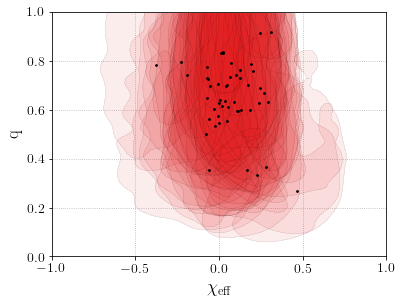

In [38]:
fig,ax = plt.subplots(figsize=(6,4.5))
chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for key in list(reweightedSampleDict.keys()):
    
    chis = reweightedSampleDict[key]['x']
    qs = reweightedSampleDict[key]['q']

    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,2.1)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    if np.median(qs)<0.45:
        print(key,np.median(chis),np.median(qs))
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',alpha=0.08)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

plt.savefig('injection_blob.pdf',bbox_inches='tight')
plt.show()

# Reweighting and mock catalog generation

In [27]:
def calculate_Gaussian(x, mu, sigma2, low, high):
    norm = np.sqrt(sigma2*np.pi/2)*(-erf((low-mu)/np.sqrt(2*sigma2)) + erf((high-mu)/np.sqrt(2*sigma2)))
    y = (1.0/norm)*np.exp((-1.0*(x-mu)*(x-mu))/(2.*sigma2))
    y[y!=y] = 0.
    return y

# Load mock detections
ref_a1 = -2
ref_a2 = -4
ref_m0 = 40
ref_mMin = 5.
ref_mMax = 100.
ref_bq = 0.5
ref_kappa = 2.
ref_mu = 0.
ref_chi = 1.

with open('/home/thomas.callister/RedshiftDistributions/spin-evolution/code/injections/population.json','r') as jf:
    mockDetections = json.load(jf)
m1_det = np.array(list(mockDetections['m1'].values()))
m2_det = np.array(list(mockDetections['m2'].values()))
s1z_det = np.array(list(mockDetections['a1'].values()))
s2z_det = np.array(list(mockDetections['a2'].values()))
z_det = np.array(list(mockDetections['z'].values()))

# Derived quantities
q_det = m2_det/m1_det
mtot_det = m1_det+m2_det
X_det = (m1_det*s1z_det + m2_det*s2z_det)/(m1_det+m2_det)

ref_p_z = np.power(1.+z_det,ref_kappa-1.)

ref_p_m1 = np.zeros(m1_det.size)
ref_p_m1[m1_det<ref_m0] = np.power(m1_det[m1_det<ref_m0]/ref_m0,ref_a1)
ref_p_m1[m1_det>=ref_m0] = np.power(m1_det[m1_det>=ref_m0]/ref_m0,ref_a2)

ref_p_m2 = np.power(m2_det,ref_bq)/(m1_det**(1.+ref_bq) - ref_mMin**(1.+ref_bq))
ref_p_xeff = calculate_Gaussian(X_det,ref_mu,ref_chi**2,-1,1)

pop_reweight = 1./(ref_p_xeff*ref_p_m1*ref_p_m2*ref_p_z)
pop_reweight[m1_det<ref_mMin] = 0.
pop_reweight[m2_det<ref_mMin] = 0.

In [27]:
mock_q_noEvol = np.zeros((len(posteriors),n_catalogs))
mock_x_noEvol = np.zeros((len(posteriors),n_catalogs))

resampled_q_noEvol = np.zeros((len(posteriors),n_catalogs))
resampled_x_noEvol = np.zeros((len(posteriors),n_catalogs))

mu_chi = np.zeros(n_catalogs)
logsig_chi = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps_no_evol.shape[0]))
    
    mMin = 5.
    lmbda1 = samps_no_evol[samp,0]
    lmbda2 = samps_no_evol[samp,1]
    m0 = samps_no_evol[samp,2]
    bq = samps_no_evol[samp,3]
    kappa = samps_no_evol[samp,4]
    mu0 = samps_no_evol[samp,5]
    logsig0 = samps_no_evol[samp,6]
    
    mu_chi[i] = mu0
    logsig_chi[i] = logsig0
    
    mock_p_m1 = np.ones(m1_det.size)
    low_ms = m1_det<m0
    high_ms = m1_det>=m0
    p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
    mock_p_m1[low_ms] = p_m1_norm*np.power(m1_det[low_ms]/m0,lmbda1)
    mock_p_m1[high_ms] = p_m1_norm*np.power(m1_det[high_ms]/m0,lmbda2)   
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    mock_p_chi = calculate_Gaussian(X_det, mu0, 10.**(2.*logsig0),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors),p=p_det,replace=True)
    mock_q_noEvol[:,i] = q_det[detected_injections]
    mock_x_noEvol[:,i] = X_det[detected_injections]

    for ii,key in enumerate(posteriors):

        chis = posteriors[key]['Xeff']
        Xeff_prior = posteriors[key]['Xeff_priors']
        m1s = posteriors[key]['m1']
        m2s = posteriors[key]['m2']
        zs = posteriors[key]['z']
        weights = posteriors[key]['weights']
        qs = m2s/m1s

        p_Chi = calculate_Gaussian(chis, mu0, 10.**(2.*logsig0),-1.,1.)

        # p(m1)
        p_m1 = np.ones(m1s.size)
        low_ms = m1s<m0
        high_ms = m1s>=m0
        p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
        p_m1[low_ms] = p_m1_norm*np.power(m1s[low_ms]/m0,lmbda1)
        p_m1[high_ms] = p_m1_norm*np.power(m1s[high_ms]/m0,lmbda2)
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q_noEvol[ii,i] = qs[chosenInd]
        resampled_x_noEvol[ii,i] = chis[chosenInd]

In [28]:
mock_q = np.zeros((len(sampleDict),n_catalogs))
mock_x = np.zeros((len(sampleDict),n_catalogs))

resampled_q = np.zeros((len(sampleDict),n_catalogs))
resampled_x = np.zeros((len(sampleDict),n_catalogs))

mu_chi_evol = np.zeros(n_catalogs)
logsig_chi_evol = np.zeros(n_catalogs)
alpha_evol = np.zeros(n_catalogs)
beta_evol = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps.shape[0]))
    
    mMin = 5.
    lmbda1 = samps[samp,0]
    lmbda2 = samps[samp,1]
    m0 = samps[samp,2]
    bq = samps[samp,3]
    kappa = samps[samp,4]
    mu0 = samps[samp,5]
    logsig0 = samps[samp,6]
    alpha = samps[samp,7]
    beta = samps[samp,8]
    
    mu_chi_evol[i] = mu0
    logsig_chi_evol[i] = logsig0    
    alpha_evol[i] = alpha
    beta_evol[i] = beta
    
    mock_p_m1 = np.ones(m1_det.size)
    low_ms = m1_det<m0
    high_ms = m1_det>=m0
    p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
    mock_p_m1[low_ms] = p_m1_norm*np.power(m1_det[low_ms]/m0,lmbda1)
    mock_p_m1[high_ms] = p_m1_norm*np.power(m1_det[high_ms]/m0,lmbda2)   
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    
    mu = mu0 + alpha*(q_det-0.5)
    logsig = logsig0 + beta*(q_det-0.5)
    mock_p_chi = calculate_Gaussian(X_det, mu, 10.**(2.*logsig),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    detected_injections = np.random.choice(np.arange(m1_det.size),size=len(sampleDict),p=p_det,replace=False)
    mock_q[:,i] = q_det[detected_injections]
    mock_x[:,i] = X_det[detected_injections]

    for ii,key in enumerate(sampleDict):

        chis = sampleDict[key]['Xeff']
        Xeff_prior = sampleDict[key]['Xeff_priors']
        m1s = sampleDict[key]['m1']
        m2s = sampleDict[key]['m2']
        zs = sampleDict[key]['z']
        weights = sampleDict[key]['weights']
        qs = m2s/m1s
        
        mu = mu0 + alpha*(qs-0.5)
        logsig = logsig0 + beta*(qs-0.5)
        p_Chi = calculate_Gaussian(chis, mu, 10.**(2.*logsig),-1.,1.)

        # p(m1)
        p_m1 = np.ones(m1s.size)
        low_ms = m1s<m0
        high_ms = m1s>=m0
        p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
        p_m1[low_ms] = p_m1_norm*np.power(m1s[low_ms]/m0,lmbda1)
        p_m1[high_ms] = p_m1_norm*np.power(m1s[high_ms]/m0,lmbda2)
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q[ii,i] = qs[chosenInd]
        resampled_x[ii,i] = chis[chosenInd]

# Blob plot, reweighted to non-evolving population

(0.0, 1.0)

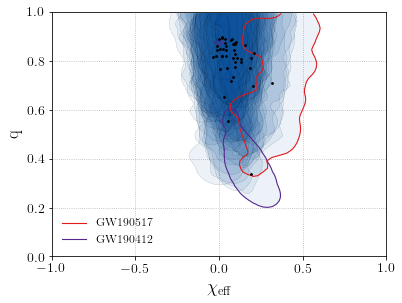

In [172]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(resampled_q_noEvol.shape[0]):
    
    chis = resampled_x_noEvol[i,:]
    qs = resampled_q_noEvol[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    i190517=np.where(np.array(list(posteriors.keys()))=='S190517h')[0][0]
    i190412=np.where(np.array(list(posteriors.keys()))=='S190412m')[0][0]
    
    if i==i190517:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif i==i190412:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)


    ###elif key=='S190412m':
    ###    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    ###elif key=='S190814bv':
    ###    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#4daf4a',linewidths=1.1)
    ###else:
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)
 

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

#plt.savefig('./reweighted_posterior_scatter_noEvolution.pdf',bbox_inches='tight')

(0.0, 1.0)

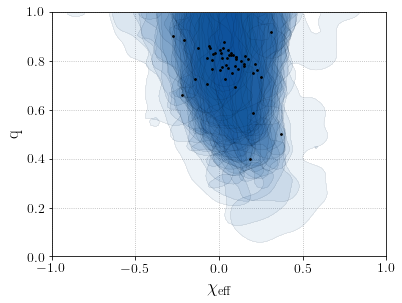

In [29]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(resampled_q.shape[0]):
    
    chis = resampled_x[i,:]
    qs = resampled_q[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,2)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)


    ###elif key=='S190412m':
    ###    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    ###elif key=='S190814bv':
    ###    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#4daf4a',linewidths=1.1)
    ###else:
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)
 

"""custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)"""

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)



# Residual Plots

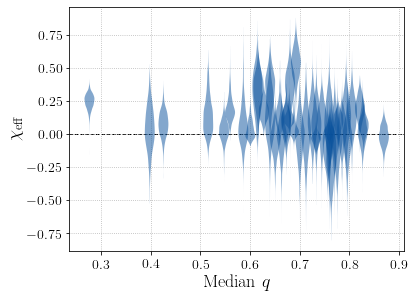

In [160]:
# Default posteriors
fig,ax = plt.subplots(figsize=(6,4.5))
    
median_qs = [np.median(posteriors[k]['m2']/posteriors[k]['m1']) for k in posteriors]
q_sorting = np.argsort(median_qs)

vs = ax.violinplot(np.array([posteriors[k]['Xeff'] for k in posteriors]).T,positions=median_qs,widths=0.02,showextrema=False)
for v in vs['bodies']:
    v.set_facecolor('#08519c')
    v.set_alpha(0.5)

ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel('Median $q$',fontsize=18)
ax.set_ylabel('$\chi_\mathrm{eff}$',fontsize=18)

plt.show()

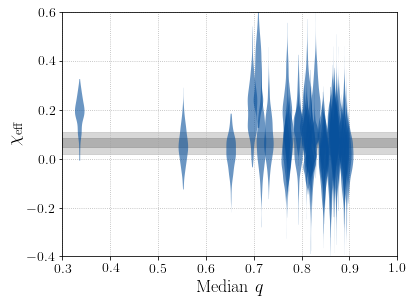

In [230]:
fig,ax = plt.subplots(figsize=(6,4.5))
    
median_qs = np.median(resampled_q_noEvol,axis=1)
q_sorting = np.argsort(median_qs)

mu_05,mu_25,mu_75,mu_95 = np.quantile(mu_chi,[0.05,0.25,0.75,0.95])
ax.fill_between([0,1],mu_05,mu_95,color='#bdbdbd',alpha=0.6)
ax.fill_between([0,1],mu_25,mu_75,color='#969696',alpha=0.6)

vs = ax.violinplot((resampled_x_noEvol).T,positions=median_qs,widths=0.02,showextrema=False)
for v in vs['bodies']:
    v.set_facecolor('#08519c')
    v.set_alpha(0.6)

"""
ax.errorbar(median_qs,np.median(resampled_x_noEvol,axis=1),ls="none",marker='o',color="#08519c",
           yerr=[np.quantile(resampled_x_noEvol,0.95,axis=1)-np.median(resampled_x_noEvol,axis=1),
                 np.median(resampled_x_noEvol,axis=1)-np.quantile(resampled_x_noEvol,0.05,axis=1)])
"""      
#ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel('Median $q$',fontsize=18)
ax.set_ylabel('$\chi_\mathrm{eff}$',fontsize=18)
ax.set_xlim(0.3,1.)
ax.set_ylim(-0.4,0.6)

plt.savefig('./default_population_residuals.pdf',bbox_inches='tight')

plt.show()

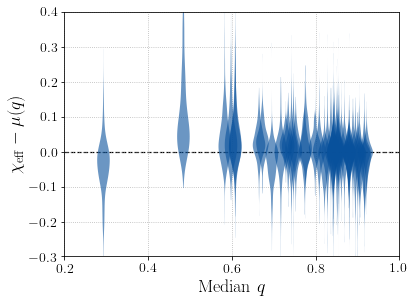

In [256]:
fig,ax = plt.subplots(figsize=(6,4.5))
    
median_qs = np.median(resampled_q,axis=1)
q_sorting = np.argsort(median_qs)
pop_means = mu_chi_evol + alpha_evol*(resampled_q-0.5)

vs = ax.violinplot((resampled_x-pop_means).T,positions=median_qs,widths=0.03,showextrema=False)
for v in vs['bodies']:
    v.set_facecolor('#08519c')
    v.set_alpha(0.6)

ax.axhline(y=0,ls='--',color='black',zorder=-1,lw=1.2)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel('Median $q$',fontsize=18)
ax.set_ylabel('$\chi_\mathrm{eff} - \mu(q)$',fontsize=18)
ax.set_xlim(0.2,1.)
ax.set_ylim(-0.3,0.4)

#plt.savefig('./default_population_residuals.pdf',bbox_inches='tight')

plt.show()

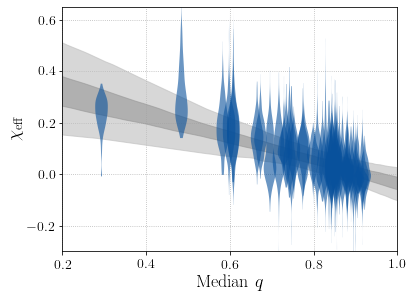

In [276]:
fig,ax = plt.subplots(figsize=(6,4.5))
    
median_qs = np.median(resampled_q,axis=1)
q_sorting = np.argsort(median_qs)

qs = np.linspace(0,1,100)
pop_means = np.array([mu_chi_evol[i] + alpha_evol[i]*(qs-0.5) for i in range(500)])
ax.fill_between(qs,np.quantile(pop_means,0.05,axis=0),np.quantile(pop_means,0.95,axis=0),color='#bdbdbd',alpha=0.6)
ax.fill_between(qs,np.quantile(pop_means,0.25,axis=0),np.quantile(pop_means,0.75,axis=0),color='#969696',alpha=0.6)


vs = ax.violinplot((resampled_x).T,positions=median_qs,widths=0.03,showextrema=False)
for v in vs['bodies']:
    v.set_facecolor('#08519c')
    v.set_alpha(0.6)

#ax.axhline(y=0,ls='--',color='black',zorder=-1,lw=1.2)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel('Median $q$',fontsize=18)
ax.set_ylabel('$\chi_\mathrm{eff}$',fontsize=18)
ax.set_xlim(0.2,1.)
ax.set_ylim(-0.3,0.65)

plt.savefig('./evolving_population_residuals.pdf',bbox_inches='tight')

plt.show()

# Predictive check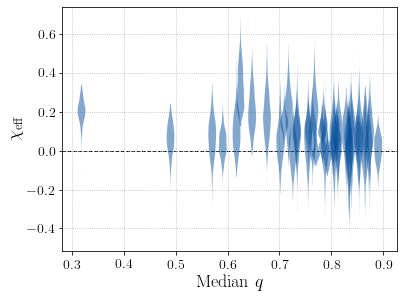

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


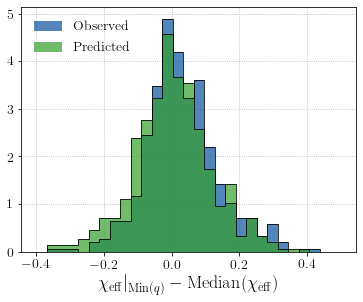

In [10]:
diffs_minQ_medQ_chi = np.zeros(n_catalogs)
mock_diffs_minQ_medQ_chi = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    ind_minq = np.argmin(resampled_q_noEvol[:,i])
    mock_ind_minq = np.argmin(mock_q_noEvol[:,i])
    
    diffs_minQ_medQ_chi[i] = resampled_x_noEvol[ind_minq,i] - np.median(resampled_x_noEvol[:,i])
    mock_diffs_minQ_medQ_chi[i] = mock_x_noEvol[mock_ind_minq,i] - np.median(mock_x_noEvol[:,i])
    
fig,ax = plt.subplots(figsize=(6,4.5))

ax.hist(diffs_minQ_medQ_chi,density=True,bins=np.linspace(-0.4,0.5,30),label='Observed',color='#08519c',alpha=0.7)
ax.hist(diffs_minQ_medQ_chi,histtype='step',density=True,bins=np.linspace(-0.4,0.5,30),color='black',lw=0.8)

ax.hist(mock_diffs_minQ_medQ_chi,density=True,bins=np.linspace(-0.4,0.5,30),alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_diffs_minQ_medQ_chi,histtype='step',density=True,bins=np.linspace(-0.4,0.5,30),color='black',lw=0.8)

ax.set_xlabel(r'$\chi_\mathrm{eff}|_{\mathrm{Min}(q)} - \mathrm{Median}(\chi_\mathrm{eff})$',fontsize=18)
ax.legend(loc='upper left',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
#plt.savefig('ppc_noEvolution.pdf',bbox_inches='tight')
plt.show()

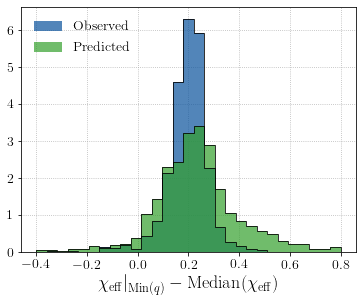

In [15]:
diffs_minQ_medQ_chi = np.zeros(n_catalogs)
mock_diffs_minQ_medQ_chi = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    ind_minq = np.argmin(resampled_q[:,i])
    mock_ind_minq = np.argmin(mock_q[:,i])
    
    diffs_minQ_medQ_chi[i] = resampled_x[ind_minq,i] - np.median(resampled_x[:,i])
    mock_diffs_minQ_medQ_chi[i] = mock_x[mock_ind_minq,i] - np.median(mock_x[:,i])
    
fig,ax = plt.subplots(figsize=(6,4.5))

ax.hist(diffs_minQ_medQ_chi,density=True,bins=np.linspace(-0.4,0.8,30),label='Observed',color='#08519c',alpha=0.7)
ax.hist(diffs_minQ_medQ_chi,histtype='step',density=True,bins=np.linspace(-0.4,0.8,30),color='black',lw=0.8)

ax.hist(mock_diffs_minQ_medQ_chi,density=True,bins=np.linspace(-0.4,0.8,30),alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_diffs_minQ_medQ_chi,histtype='step',density=True,bins=np.linspace(-0.4,0.8,30),color='black',lw=0.8)
ax.set_xlabel(r'$\chi_\mathrm{eff}|_{\mathrm{Min}(q)} - \mathrm{Median}(\chi_\mathrm{eff})$',fontsize=18)
ax.legend(loc='upper left',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
#plt.savefig('ppc_yesEvolution.pdf',bbox_inches='tight')
plt.show()

# PPC Testing

In [112]:
obs_q_max = np.zeros(n_catalogs)
obs_q_min = np.zeros(n_catalogs)
mock_q_max = np.zeros(n_catalogs)
mock_q_min = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol[:,i]
    mock_qs = mock_q_noEvol[:,i]
    obs_xs = resampled_x_noEvol[:,i]
    mock_xs = mock_x_noEvol[:,i]
    
    mus = mu_chi[i]
    logsigs = logsig_chi[i]
    
    ind = 1
    obs_q_max[i] = obs_qs[np.argsort(obs_xs)[-ind-1]]
    obs_q_min[i] = obs_qs[np.argsort(obs_xs)[ind]]
    
    mock_q_max[i] = mock_qs[np.argsort(mock_xs)[-ind-1]]
    mock_q_min[i] = mock_qs[np.argsort(mock_xs)[ind]]

In [113]:
np.mean(mock_q_max-mock_q_min)

-0.00033556825373608256

In [114]:
print(np.mean(obs_q_max-obs_q_min),np.std(obs_q_max-obs_q_min)/np.sqrt(n_catalogs))

-0.06741387045051263 0.008917560943958827


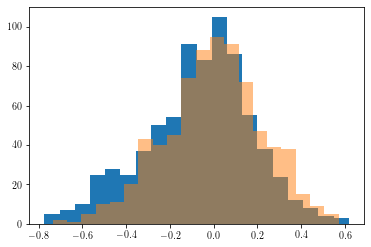

0.56

In [115]:
plt.hist(obs_q_max-obs_q_min,bins=20)
plt.hist(mock_q_max-mock_q_min,bins=20,alpha=0.5)
plt.show()

np.where(obs_q_max-obs_q_min<mock_q_max-mock_q_min)[0].size/n_catalogs

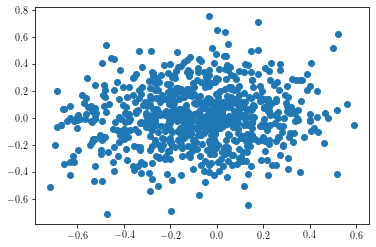

In [103]:
plt.scatter(obs_q_max-obs_q_min,mock_q_max-mock_q_min)

In [123]:
obs_slope = np.zeros(n_catalogs)
mock_slope = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol[:,i]
    mock_qs = mock_q_noEvol[:,i]
    obs_xs = resampled_x_noEvol[:,i]
    mock_xs = mock_x_noEvol[:,i]
    
    mus = mu_chi[i]
    logsigs = logsig_chi[i]
    
    obs_slope[i] = (obs_qs[np.argmax(obs_xs)] - obs_qs[np.argmin(obs_xs)])/(np.max(obs_xs)-np.min(obs_xs))
    mock_slope[i] = (mock_qs[np.argmax(mock_xs)] - mock_qs[np.argmin(mock_xs)])/(np.max(mock_xs)-np.min(mock_xs))

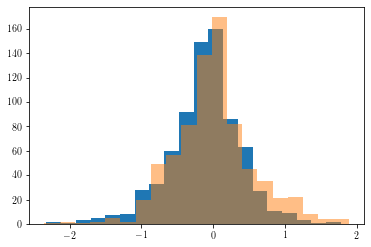

0.5693333333333334


In [124]:
plt.hist(obs_slope,bins=20)
plt.hist(mock_slope,bins=20,alpha=0.5)
plt.show()
print(np.where(obs_slope<mock_slope)[0].size/n_catalogs)

In [149]:
obs_slope = np.zeros(n_catalogs)
mock_slope = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol[:,i]
    mock_qs = mock_q_noEvol[:,i]
    obs_xs = resampled_x_noEvol[:,i]
    mock_xs = mock_x_noEvol[:,i]
    
    X = np.transpose([np.ones(obs_qs.size),obs_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(obs_xs)
    obs_slope[i] = m
    
    X = np.transpose([np.ones(mock_qs.size),mock_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(mock_xs)
    mock_slope[i] = m

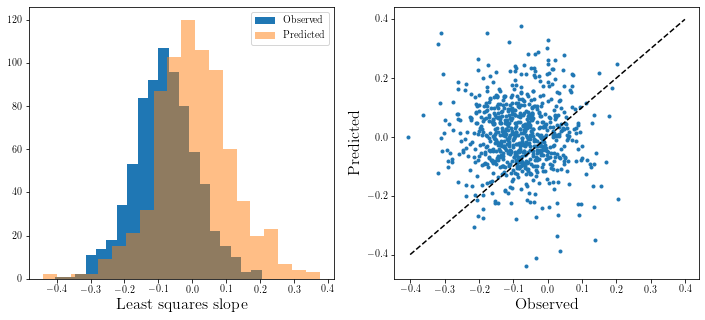

In [155]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
ax.hist(obs_slope,label='Observed',bins=20)
ax.hist(mock_slope,alpha=0.5,label='Predicted',bins=20)
plt.legend()
ax.set_xlabel("Least squares slope",fontsize=16)

ax = fig.add_subplot(122)
ax.scatter(obs_slope,mock_slope,marker='.')
ax.plot([-0.4,0.4],[-0.4,0.4],color='black',ls='--')
ax.set_xlabel("Observed",fontsize=16)
ax.set_ylabel("Predicted",fontsize=16)

plt.show()

In [156]:
obs_slope = np.zeros(n_catalogs)
mock_slope = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q[:,i]
    mock_qs = mock_q[:,i]
    obs_xs = resampled_x[:,i]
    mock_xs = mock_x[:,i]
    
    X = np.transpose([np.ones(obs_qs.size),obs_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(obs_xs)
    obs_slope[i] = m
    
    X = np.transpose([np.ones(mock_qs.size),mock_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(mock_xs)
    mock_slope[i] = m

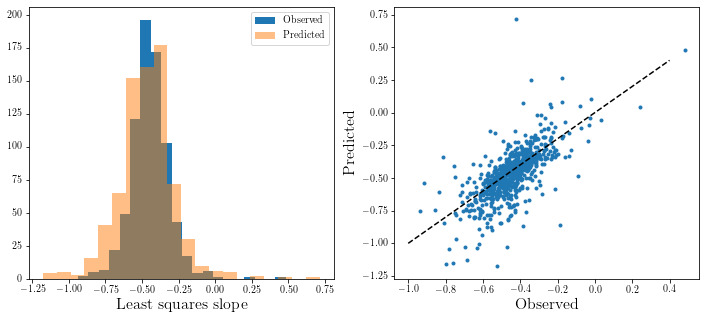

In [158]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
ax.hist(obs_slope,label='Observed',bins=20)
ax.hist(mock_slope,alpha=0.5,label='Predicted',bins=20)
plt.legend()
ax.set_xlabel("Least squares slope",fontsize=16)

ax = fig.add_subplot(122)
ax.scatter(obs_slope,mock_slope,marker='.')
ax.plot([-1,0.4],[-1,0.4],color='black',ls='--')
ax.set_xlabel("Observed",fontsize=16)
ax.set_ylabel("Predicted",fontsize=16)

plt.show()

In [147]:
np.where(obs_slope<mock_slope)[0].size/n_catalogs

0.42933333333333334

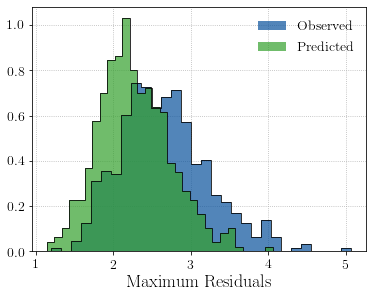

0.708


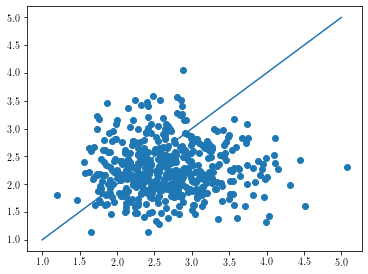

In [159]:
counts = np.zeros(n_catalogs)
mock_counts = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol[:,i]
    mock_qs = mock_q_noEvol[:,i]
    obs_xs = resampled_x_noEvol[:,i]
    mock_xs = mock_x_noEvol[:,i]
    
    qlow = 0.
    dq = 1.
    if np.any((obs_qs>qlow)*(obs_qs<qlow+dq)):
        counts[i] = (np.max(obs_xs[(obs_qs>qlow)*(obs_qs<qlow+dq)]) - mu_chi[i])/(10.**logsig_chi[i])
    if np.any((mock_qs>qlow)*(mock_qs<qlow+dq)):
        mock_counts[i] = (np.max(mock_xs[(mock_qs>qlow)*(mock_qs<qlow+dq)]) - mu_chi[i])/(10.**logsig_chi[i])
    
fig,ax = plt.subplots(figsize=(6,4.5))
ax.hist(counts[counts!=0],density=True,bins=30,label='Observed',color='#08519c',alpha=0.7)
ax.hist(counts[counts!=0],histtype='step',density=True,bins=30,color='black',lw=0.8)
ax.hist(mock_counts[mock_counts!=0],density=True,bins=30,alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_counts[mock_counts!=0],histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.set_xlabel(r'Maximum Residuals',fontsize=18)
ax.legend(loc='upper right',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
plt.savefig('ppc_residual_noEvolution.pdf',bbox_inches='tight')
plt.show()

print(np.where(counts>mock_counts)[0].size/counts.size)

fig,ax = plt.subplots(figsize=(6,4.5))
ax.scatter(counts[counts!=0],mock_counts[mock_counts!=0])
ax.plot([1,5],[1,5])
plt.show()

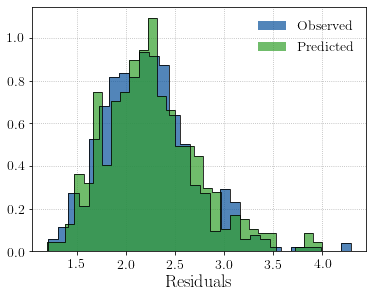

0.508


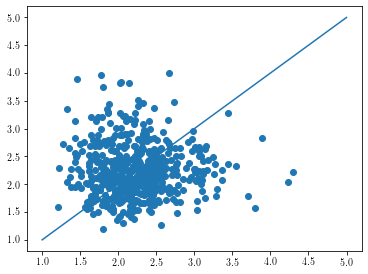

In [150]:
counts = np.zeros(n_catalogs)
mock_counts = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q[:,i]
    mock_qs = mock_q[:,i]
    obs_xs = resampled_x[:,i]
    mock_xs = mock_x[:,i]
    
    mus = mu_chi_evol[i] + alpha_evol[i]*(obs_qs - 0.5)
    logsigs = logsig_chi_evol[i] + beta_evol[i]*(obs_qs - 0.5)
    counts[i] = np.max((obs_xs - mus)/(10.**logsigs))
    
    mock_mus = mu_chi_evol[i] + alpha_evol[i]*(mock_qs - 0.5)
    mock_logsigs = logsig_chi_evol[i] + beta_evol[i]*(mock_qs - 0.5)
    mock_counts[i] = np.max((mock_xs - mock_mus)/(10.**mock_logsigs))
    
fig,ax = plt.subplots(figsize=(6,4.5))

ax.hist(counts,density=True,bins=30,label='Observed',color='#08519c',alpha=0.7)
ax.hist(counts,histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.hist(mock_counts,density=True,bins=30,alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_counts,histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.set_xlabel(r'Residuals',fontsize=18)
ax.legend(loc='upper right',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
plt.savefig('ppc_residual.pdf',bbox_inches='tight')
plt.show()

print(np.where(counts>mock_counts)[0].size/counts.size)

fig,ax = plt.subplots(figsize=(6,4.5))
ax.scatter(counts[counts!=0],mock_counts[mock_counts!=0])
ax.plot([1,5],[1,5])
plt.show()

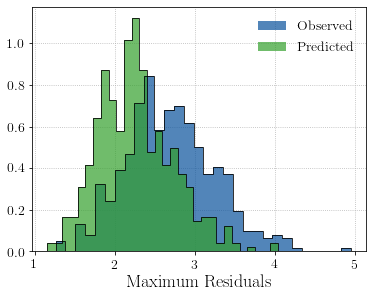

0.732


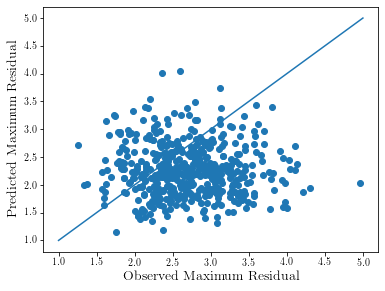

In [148]:
counts = np.zeros(n_catalogs)
mock_counts = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol_no190412[:,i]
    mock_qs = mock_q_noEvol_no190412[:,i]
    obs_xs = resampled_x_noEvol_no190412[:,i]
    mock_xs = mock_x_noEvol_no190412[:,i]
    
    qlow = 0.
    dq = 1.
    if np.any((obs_qs>qlow)*(obs_qs<qlow+dq)):
        counts[i] = (np.max(obs_xs[(obs_qs>qlow)*(obs_qs<qlow+dq)]) - mu_chi_no190412[i])/(10.**logsig_chi_no190412[i])
    if np.any((mock_qs>qlow)*(mock_qs<qlow+dq)):
        mock_counts[i] = (np.max(mock_xs[(mock_qs>qlow)*(mock_qs<qlow+dq)]) - mu_chi_no190412[i])/(10.**logsig_chi_no190412[i])
    
fig,ax = plt.subplots(figsize=(6,4.5))

ax.hist(counts[counts!=0],density=True,bins=30,label='Observed',color='#08519c',alpha=0.7)
ax.hist(counts[counts!=0],histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.hist(mock_counts[mock_counts!=0],density=True,bins=30,alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_counts[mock_counts!=0],histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.set_xlabel(r'Maximum Residuals',fontsize=18)
ax.legend(loc='upper right',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
plt.savefig('ppc_residual_noEvolution_no190412.pdf',bbox_inches='tight')
plt.show()

print(np.where(counts>mock_counts)[0].size/counts.size)

fig,ax = plt.subplots(figsize=(6,4.5))
ax.scatter(counts[counts!=0],mock_counts[mock_counts!=0])
ax.set_xlabel('Observed Maximum Residual',fontsize=14)
ax.set_ylabel('Predicted Maximum Residual',fontsize=14)
ax.plot([1,5],[1,5])
plt.show()

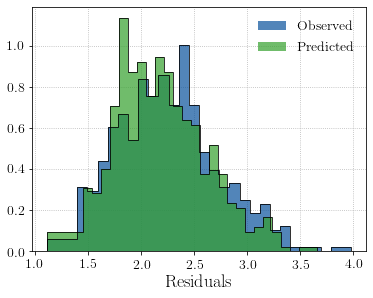

0.538


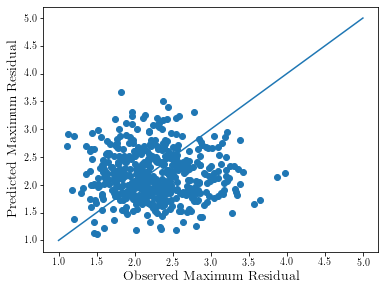

In [151]:
counts = np.zeros(n_catalogs)
mock_counts = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_no190412[:,i]
    mock_qs = mock_q_no190412[:,i]
    obs_xs = resampled_x_no190412[:,i]
    mock_xs = mock_x_no190412[:,i]
    
    mus = mu_chi_evol_no190412[i] + alpha_evol_no190412[i]*(obs_qs - 0.5)
    logsigs = logsig_chi_evol_no190412[i] + beta_evol_no190412[i]*(obs_qs - 0.5)
    counts[i] = np.max((obs_xs - mus)/(10.**logsigs))
    
    mock_mus = mu_chi_evol_no190412[i] + alpha_evol_no190412[i]*(mock_qs - 0.5)
    mock_logsigs = logsig_chi_evol_no190412[i] + beta_evol_no190412[i]*(mock_qs - 0.5)
    mock_counts[i] = np.max((mock_xs - mock_mus)/(10.**mock_logsigs))
    
fig,ax = plt.subplots(figsize=(6,4.5))

ax.hist(counts,density=True,bins=30,label='Observed',color='#08519c',alpha=0.7)
ax.hist(counts,histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.hist(mock_counts,density=True,bins=30,alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_counts,histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.set_xlabel(r'Residuals',fontsize=18)
ax.legend(loc='upper right',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
plt.savefig('ppc_residual_no190412.pdf',bbox_inches='tight')
plt.show()

print(np.where(counts>mock_counts)[0].size/counts.size)

fig,ax = plt.subplots(figsize=(6,4.5))
ax.scatter(counts[counts!=0],mock_counts[mock_counts!=0])
ax.set_xlabel('Observed Maximum Residual',fontsize=14)
ax.set_ylabel('Predicted Maximum Residual',fontsize=14)
ax.plot([1,5],[1,5])
plt.show()

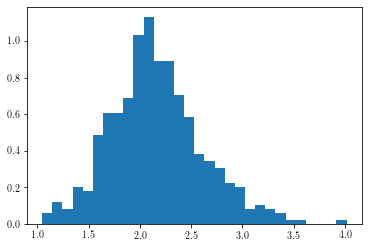

In [103]:
test = [np.max(np.random.normal(loc=0,scale=1,size=44)) for i in range(500)]
fig,ax = plt.subplots()
ax.hist(test,density=True,bins=30)
plt.show()

# Corner Plots

In [32]:
# Helper function to obtain 90% credible bounds from a list of samples
# Invoked by plot_corner to create labels on 1D posteriors
def getBounds(data):
    
    # Transform to a numpy arry
    data = np.array(data)

    # Get median, 5% and 95% quantiles
    med = np.median(data)
    upperLim = np.sort(data)[int(0.95*data.size)]
    lowerLim = np.sort(data)[int(0.05*data.size)]
 
    # Turn quantiles into upper and lower uncertainties
    upperError = upperLim-med
    lowerError = med-lowerLim
    
    return med,upperError,lowerError
    
def plot_corner(fig,plot_data,color,hist_alpha=0.7,bins=20,labelsize=14):
    
    # Input variable plot_data should be a dictionary whose keys are the individual variables to plot.
    # Each key should, in turn, link to another nested dictionary with the following keys:
    # - "data" : Actual data values
    # - "plot_bounds" : Tuple of min/max values to display on plot
    # - "label" : Latex string for figure labeling

    # Define a linear color map
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",color])
    
    # Loop across dimensions that we want to plot
    keys = list(plot_data)    
    ndim = len(keys)
    for i,key in enumerate(keys):
       
        # Plot the marginal 1D posterior (i.e. top of a corner plot column)
        ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
        ax.set_rasterization_zorder(1)
        
        ax.hist(plot_data[key]['data'],bins=np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],bins),\
               rasterized=True,color=color,alpha=hist_alpha,density=True,zorder=0)
        ax.hist(plot_data[key]['data'],bins=np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],bins),\
                histtype='step',color='black',density=True,zorder=2)
        ax.grid(True,dashes=(1,3))
        ax.set_xlim(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1])
        ax.set_title(r"${0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(*getBounds(plot_data[key]['data'])),fontsize=14)

        # Turn off tick labels if this isn't the first dimension
        if i!=0:
            ax.set_yticklabels([])

        # If this is the last dimension add an x-axis label
        if i==ndim-1:
            ax.set_xlabel(plot_data[key]['label'],fontsize=labelsize)
            
        # If not the last dimension, loop across other variables and fill in the rest of the column with 2D plots
        else:
            
            ax.set_xticklabels([])
            for j,k in enumerate(keys[i+1:]):
                
                # Make a 2D density plot
                ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))
                ax.set_rasterization_zorder(1)
                
                ax.hexbin(plot_data[key]['data'],plot_data[k]['data'],cmap=cmap,mincnt=1,gridsize=bins,\
                         extent=(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1]),
                         linewidths=(0,),zorder=0)
                
                xgrid = np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],100)
                ygrid = np.linspace(plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1],100)
                heights,edgex,edgey = np.histogram2d(plot_data[key]['data'],plot_data[k]['data'],
                                                     bins=(xgrid,ygrid))
                heights = gaussian_filter(heights,2)
                heights /= np.sum(heights)*dchi*dq
                heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
                cdf = np.cumsum(heights_large_to_small)*dchi*dq

                num_grid_pts = np.where(cdf>0.9)[0][0]
                h50 = np.interp(0.5,cdf,heights_large_to_small)
                h90 = np.interp(0.9,cdf,heights_large_to_small)
                ax.contour((xgrid[:-1]+xgrid[1:])/2,(ygrid[:-1]+ygrid[1:])/2,heights.T,levels=(h90,h50,np.inf),colors='black',linewidths=1.1)
                
                # Set plot bounds
                ax.set_xlim(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1])
                ax.set_ylim(plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1])
                ax.grid(True,dashes=(1,3))
                
                # If still in the first column, add a y-axis label
                if i==0:
                    ax.set_ylabel(plot_data[k]['label'],fontsize=labelsize)
                else:
                    ax.set_yticklabels([])
               
                # If on the last row, add an x-axis label
                if j==ndim-i-2:
                    ax.set_xlabel(plot_data[key]['label'],fontsize=labelsize)
                else:
                    ax.set_xticklabels([])
                    
    plt.tight_layout()    
    return fig

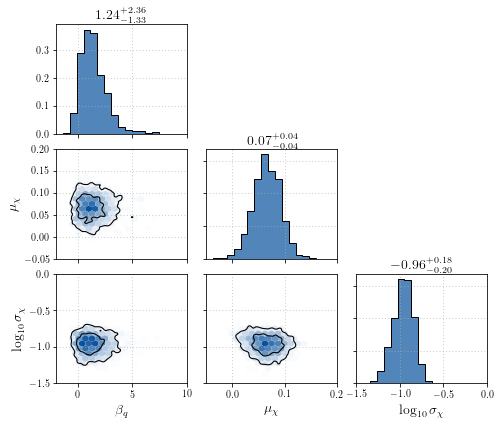

In [34]:
toPlot = {
    'beta':{'data':samps_no_evol[:,3],'plot_bounds':(-2,10),'label':r'$\beta_q$'},
    'mu0':{'data':samps_no_evol[:,5],'plot_bounds':(-0.05,0.2),'label':r'$\mu_\chi$'},
    'sig0':{'data':samps_no_evol[:,6],'plot_bounds':(-1.5,0.),'label':r'$\log_{10}\sigma_\chi$'}
    }

fig = plt.figure(figsize=(7,6))
plot_corner(fig,toPlot,'#08519c')
fig.subplots_adjust(wspace=0.15, hspace=0.14)
plt.savefig('./corner_noEvolution.pdf',bbox_inches='tight')
plt.show()

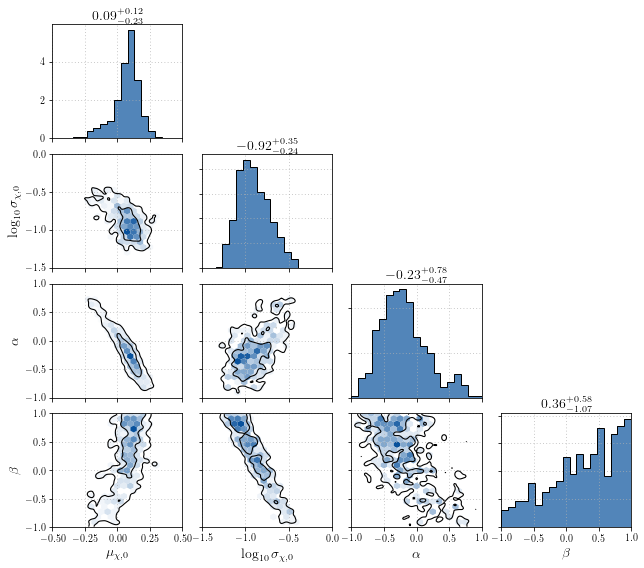

In [43]:
toPlot = {
    'mu0':{'data':samps[:,5],'plot_bounds':(-0.5,0.5),'label':r'$\mu_{\chi,0}$'},
    'sig0':{'data':samps[:,6],'plot_bounds':(-1.5,0.),'label':r'$\log_{10}\sigma_{\chi,0}$'},
    'a':{'data':samps[:,7],'plot_bounds':(-1.,1),'label':r'$\alpha$'},
    'b':{'data':samps[:,8],'plot_bounds':(-1,1),'label':r'$\beta$'}
    }

fig = plt.figure(figsize=(9,8))
plot_corner(fig,toPlot,'#08519c')
fig.subplots_adjust(wspace=0.15, hspace=0.14)
plt.show()

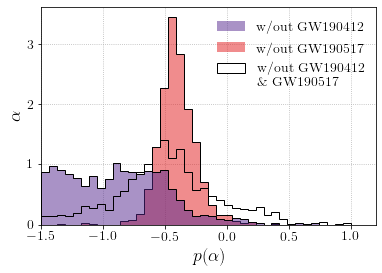

In [430]:
from matplotlib.patches import Rectangle

samps_no190517 = np.load('./../processed_emcee_samples_qDependence_no190517_r00.npy')
samps_no190412_no190517 = np.load('./../processed_emcee_samples_qDependence_no190412_no190517_r00.npy')
samps_w190814 = np.load('./../processed_emcee_samples_qDependence_w190814_betaMin-2.0.npy')

fig,ax = plt.subplots()
#facecolor='#08519c',
#ax.hist(samps[:,7],bins=np.linspace(-1.5,1,45),histtype='step',
#        color='black',alpha=0.8,label='Default',zorder=-1,lw=2

ax.hist(samps_no190412[:,7],bins=np.linspace(-1.5,1,40),histtype='stepfilled',
        color='#54278f',label='w/out GW190412',alpha=0.5,zorder=4,density=True)
ax.hist(samps_no190412[:,7],bins=np.linspace(-1.5,1,40),histtype='step',
        color='black',zorder=5,density=True)

ax.hist(samps_no190517[:,7],bins=np.linspace(-1.5,1,40),histtype='stepfilled',
        color='#e31a1c',label='w/out GW190517',alpha=0.5,zorder=2,density=True)
ax.hist(samps_no190517[:,7],bins=np.linspace(-1.5,1,40),histtype='step',
        color='black',zorder=3,density=True)

"""ax.hist(samps_w190814[:,7],bins=np.linspace(-1.5,1,40),histtype='stepfilled',
        color='#4daf4a',label='w/ GW190814',alpha=0.8,zorder=0,density=True)
ax.hist(samps_w190814[:,7],bins=np.linspace(-1.5,1,40),histtype='step',
        color='black',zorder=1,density=True)"""


ax.hist(samps_no190412_no190517[:,7],bins=np.linspace(-1.5,1,40),histtype='step',
        color='black',density=True,zorder=10)

leg2 = plt.legend([Rectangle((0,0),1,1,facecolor='white',edgecolor='black')],['w/out GW190412 \n \& GW190517'],
                  fontsize=14,frameon=False,loc=(0.51,0.63))
leg2.get_texts()[0].set_position((0,-7.5))

leg = ax.legend(loc='upper right',fontsize=14,frameon=False)
plt.gca().add_artist(leg2)

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'$p(\alpha)$',fontsize=18)
ax.set_ylabel(r'$\alpha$',fontsize=18)
ax.set_xlim(-1.5,1.2)

plt.savefig('./alpha_posterior_outInTests.pdf',bbox_inches='tight')

plt.show()

In [435]:
print(1-samps_no190517[:,7][samps_no190517[:,7]>0].size/samps_no190517[:,7].size)
print(1-samps_no190412[:,7][samps_no190412[:,7]>0].size/samps_no190412[:,7].size)
print(1-samps_no190412_no190517[:,7][samps_no190412_no190517[:,7]>0].size/samps_no190412_no190517[:,7].size)

0.9876644736842105
0.9809523809523809
0.8841911764705882
